## Answering Business Questions using SQL Project

In this project SQL will be used to answer several questions about the chinook database. This database contains information about a fictional music shop, including data on sales, employees and genres. This data is divided into multiple tables within the database and the main focus of the project will be on  complex queries and on joins to gain access to information across the different tables and to understand intermediate `SQL` concepts in `Python`

## General Setup

In [1]:
#imports
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
db = 'chinook.db'

## Function for Running Queries

In [2]:
def run_query(q):
    ''' Run an SQL query
    Args:
        q (str): the SQL query to run
    Returns:
        Pandas Dataframe with the results of the query
    '''
    with sqlite3.connect(db) as conn:
        return pd.read_sql_query(q, conn)

## Function for Running Commands

In [3]:
def run_command(c):
    '''Run an SQL command
    Args:
        c (str): the command to run
    '''
    with sqlite3.connect('chinook.db') as conn:
        return conn.execute(c)

## Function for Showing all Tables

In [4]:
def show_tables():
    '''Show all available tables in the databank
    Args:
    Returns:
        Pandas DataFrame with all tables in the databank and their type (table)
    '''
    q1 = '''SELECT
            name,
            type
    FROM sqlite_master
    WHERE type IN ("table", "view")'''
    return run_query(q1)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Data Analysis

## Finding most profitable genres in the US and plotting the results
In this exercise the objective is to select three of the four albums from the following list for the music shop to purchase by choosing albums from the most lucrative genres:

|Artist Name         |Genre  |
|--------------------|------:|
|Regal               |Hip-Hop|
|Red Tone            |Punk   |
|Meteor and the Girls|Pop    |
|Slim Jim Bites      |Blues  |


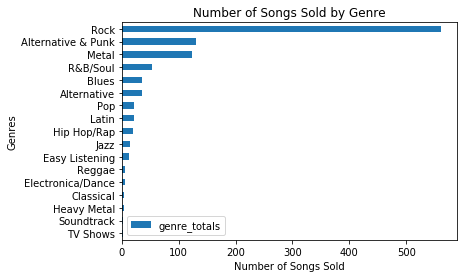

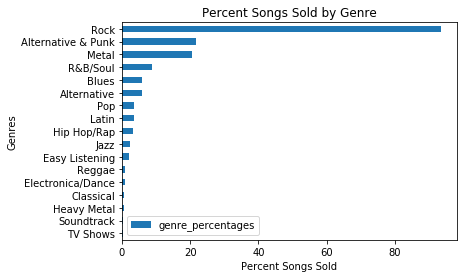

In [6]:
q2 = """
WITH usa_totals AS
    (SELECT
    i.invoice_id,
    i.billing_country country,
    i.total
    FROM invoice i 
    WHERE i.billing_country == "USA")
    


SELECT
g.name genre_name,
COUNT(ut.invoice_id) genre_totals,
CAST(COUNT(ut.invoice_id) AS float) / (SELECT COUNT(invoice_id) / 100 FROM invoice) genre_percentages
FROM track t
INNER JOIN genre g ON g.genre_id = t.genre_id
INNER JOIN invoice_line il on il.track_id = t.track_id
INNER JOIN usa_totals ut ON ut.invoice_id = il.invoice_id
GROUP BY genre_name
ORDER BY 2
"""
results = run_query(q2)
# In numbers
fig1 = results.set_index(keys = results['genre_name']).plot.barh(y = 'genre_totals')
fig1.set_title('Number of Songs Sold by Genre')
fig1.set_ylabel('Genres')
fig1.set_xlabel('Number of Songs Sold')

plt.show()

# In percentages

fig2 = results.set_index(keys = results['genre_name']).plot.barh(y = 'genre_percentages')
fig2.set_title('Percent Songs Sold by Genre')
fig2.set_ylabel('Genres')
fig2.set_xlabel('Percent Songs Sold')

plt.show()


### Results
By looking at the sales numbers, the recommendation would be to use
"Red Tone"
"Meteor and the Girls"
and "Slim Jim Bites"
because the last remaining artist "Regal" makes music in the Hip-Hop genre, which has had lower sales than the genres of all the other artists.

## Finding the best salesperson on staff

In [7]:
q3 = '''
SELECT
e.first_name || ' ' || e.last_name employee_name,
SUM(i.total) total_sales,
COUNT(i.customer_id) no_customers,
SUM(i.total)/COUNT(i.customer_id) average_sale_per_customer
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY 1
'''

run_query(q3)

,employee_name,total_sales,no_customers,average_sale_per_customer
0,Jane Peacock,1731.51,212,8.167500
1,Margaret Park,1584.00,214,7.401869
2,Steve Johnson,1393.92,188,7.414468


The table above shows, that Jane Peacock has the highest amount of revenue. She also has the highest revenue per customer on average, as even though she has 2 customers less than Margaret park, she has about $150 more in sales revenue

## Analyzing Sales Data by Country

Now the database will be analyzed relative to country regarding:

* total number of customers
* total value of sales
* average value of sales per customer
* average order value.

Countries with only one Customer will be put into the 'Other category'

In [9]:
q4 = '''
WITH single_countries AS
    (SELECT c.country, 
    count(c.customer_id) no_customers
    from customer c
    GROUP BY 1
    HAVING count(c.customer_id) = 1),
    
    multi_countries AS
    (SELECT
    c.country,
    COUNT(c.customer_id) no_customers
    FROM customer c
    GROUP BY 1
    HAVING count(c.customer_id) != 1),
    
    invoice_customers AS
    (SELECT
    customer_id,
    COUNT(invoice_id) no_invoices,
    SUM(total) sum_total
    FROM invoice
    GROUP BY customer_id),
    
    first_query as
    (SELECT
    c.country,
    COUNT(c.customer_id) total_no_customers,
    SUM(ic.sum_total) tot_val_sales,
    SUM(ic.sum_total) / COUNT(c.customer_id) avg_spent_cust,
    SUM(ic.no_invoices) no_invoices
    FROM customer c
    INNER JOIN invoice_customers ic ON ic.customer_id = c.customer_id
    GROUP BY c.country),
    
    second_query as
    (SELECT * FROM first_query
    WHERE total_no_customers != 1
    
    UNION
    
    SELECT
    'OTHER' country,
    SUM(total_no_customers) total_no_customers,
    SUM(tot_val_sales) tot_val_sales,
    AVG(avg_spent_cust) avg_spent_cust,
    SUM(no_invoices) no_invoices
    FROM first_query
    WHERE total_no_customers = 1)

SELECT
country,
total_no_customers customers,
tot_val_sales total_sales,
tot_val_sales / no_invoices average_order,
avg_spent_cust customer_total_spent
FROM
    (SELECT * ,
    CASE
        WHEN country = 'OTHER' THEN 1
        ELSE 0
    END
    AS omgwhydidthistakesolong
    FROM second_query
    ORDER BY omgwhydidthistakesolong, 3 DESC)
'''    
    
    
    
#SELECT 'Other' country, COUNT(country) no_customers from single_countries




data = run_query(q4)
data

,country,customers,total_sales,average_order,customer_total_spent
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,OTHER,15,1094.94,7.448571,72.996000


### Visualizing the results:

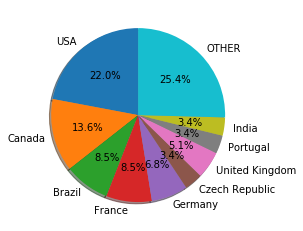

In [10]:
labels = data['country']#.tolist()
sizes = data['customers']
fig, ax1 = plt.subplots()
ax1 = plt.pie(x = data.loc[:,'customers'],
              labels = data.loc[:,'country'],
              autopct='%1.1f%%',
              shadow = True, startangle = 90)
plt.show()

In [12]:
data

,country,customers,total_sales,average_order,customer_total_spent
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,OTHER,15,1094.94,7.448571,72.996000


Text(0, 0.5, '')

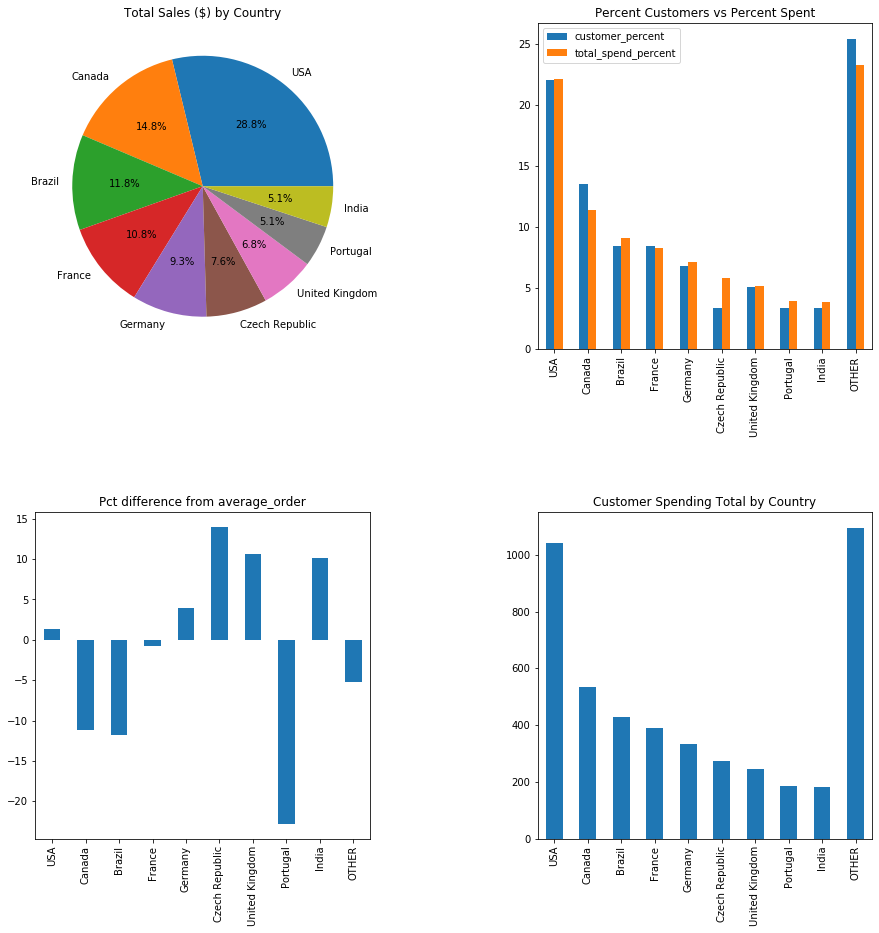

In [15]:
country_metrics = data.copy()
country_metrics.set_index('country', drop = True, inplace = True)
colors = [plt.cm.Accent(i) for i in np.linspace(0,1,country_metrics.shape[0])]

fig,axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,15))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace = .5 , wspace =.5)

# Top left, make a pie chart of the total sales
country_metrics.iloc[:-1]['total_sales'].plot.pie(ax = ax1,
                                                 autopct = '%1.1f%%',
                                                 title = 'Total Sales ($) by Country')
ax1.set_ylabel('')

#Top Right Comparing the total number of customers to the total money spent bar plot
# Find customer percentage
country_metrics['customer_percent'] = country_metrics['customers'] / country_metrics['customers'].sum() * 100
country_metrics['total_spend_percent'] = country_metrics['total_sales'] / country_metrics['total_sales'].sum() *100

country_metrics[['customer_percent', 'total_spend_percent']].plot.bar(ax = ax2,
                                                                      title = 'Percent Customers vs Percent Spent')
ax2.set_ylabel('')
ax2.set_xlabel('')

# Lower left 
((country_metrics['average_order'] - country_metrics['average_order'].mean())
 / country_metrics['average_order'] * 100).plot.bar(ax = ax3, title = 'Pct difference from average_order')
ax3.set_ylabel('')
ax3.set_xlabel('')

#Lower right 
country_metrics['total_sales'].plot.bar(ax = ax4, title = 'Customer Spending Total by Country')
ax4.set_xlabel('')
ax4.set_ylabel('')


    



# Results
The low sample size of the shop makes it difficult to draw any solid conclusions. 

It can be said however, that the two Czech customers spent the most on average.

A large part of the customer base is in the USA, so it would be prudent to expand the advertising there.

But since chinook is a fictional *online* shop, it might be a good idea to do marketed international advertising, for example on youtube music videos, especially of the artists featured in the shop, instead.

If localized marketing is preferred, combining marketing in the USA and Canada might be a good idea, as Canada has half the amount spent as the US and the cultural differences are small, so using the same marketing in Canada as in the US might allow for cheaper marketing. Together, the US and Canadian market make up 43.6% of total money spent.

### Albums or singles?

The next question to answer is if for future additions to the music shop's inventory it would be better to buy singles or whole albums would be better. To achieve this, the sales data of both types of media will be analyzed.

In [17]:
q5 = '''

WITH singles AS
    (SELECT
    MIN(il.track_id) id_min,
    t.album_id,
    il.invoice_id
    FROM invoice_line il
    LEFT JOIN track t on il.track_id = t.track_id

   
    GROUP BY il.invoice_id)
    
SELECT purchase_type,
COUNT(purchase_type) purchases,
CAST(COUNT(purchase_type) AS FLOAT) / (SELECT COUNT(invoice_id) FROM invoice) *100 purchase_pct

FROM
(SELECT 
CASE
WHEN(
    SELECT il.track_id 
    FROM invoice_line il
    WHERE il.invoice_id = s.invoice_id

EXCEPT

    SELECT t.track_id 
    FROM track t
    WHERE t.album_id = s.album_id) /*(SELECT t2.album_id FROM track t2
                         WHERE t2.track_id = s.id_min))*/

IS NULL

AND

    (SELECT t.track_id 
    FROM track t
    WHERE t.album_id = s.album_id /*(SELECT t2.album_id FROM track t2
                         WHERE t2.track_id = s.id_min)*/

EXCEPT

    SELECT il.track_id 
    FROM invoice_line il
    WHERE il.invoice_id = s.invoice_id)
    
IS NULL

THEN 'album'
ELSE 'songs'


END
AS 'purchase_type'

FROM singles s)

GROUP BY purchase_type
    '''





#This query finds a single album_id for each invoice



run_query(q5)

,purchase_type,purchases,purchase_pct
0,album,114,18.566775
1,songs,500,81.433225


### Results
A large majority of the purchases are individual songs, not as whole albums. 1/5 of all purchases are albums. Most albums contain more than five songs, meaning that album purchases make up most of the total song sales and so the revenue. So investing in buying more albums to sell on the store would be a good idea.

# Summary
In this project the chinook database, a database containing data from a fictional music shop was analyzed and several business questions were answered:

1. When adding new artists from the genres hip-hop, punk, pop and blues, which three artists should be chosen based on the sales data from their respective genres in the US?

    Add all artists except the hip-hop artist since hip-hop has not been performing well in sales in the recent data.

2. Who is the best salesperson on staff?

	Jane Peacock: both in total sales and in the amount of sales per customer (customer retention)

3. Which market is most promising for advertisement?

    * The US has the highest amount of customers and sales as well as spending in total
    * the customers in the Czech republic have spent the most per person
    * using the same marketing on the US and Canada could be a cost-effective way of promoting the store.
    
4. Should the store focus on the sale of singles or of albums?

    Albums make up about 1/5 of the total purchases. Since most albums have more than 5 songs expanding this part of the shop seems to be a good idea.